# RAW DATA - EXPLORATORY DATA ANALYSIS


## SET UP INITIAL SESSION

In [7]:
%%configure 
{
    "script_location": "s3://shivam-trial-s3/code_artefacts/glue/scripts/",
    "--TempDir": "s3://shivam-trial-s3/code_artefacts/glue/temp/"
}

You are already connected to a glueetl session f2afc7b5-3468-4d77-bcbe-26aee64b92e6.

No change will be made to the current session that is set as glueetl. The session configuration change will apply to newly created sessions.


The following configurations have been updated: {'script_location': 's3://shivam-trial-s3/code_artefacts/glue/scripts/', '--TempDir': 's3://shivam-trial-s3/code_artefacts/glue/temp/', '--additional-python-modules': 'matplotlib'}


In [1]:
%idle_timeout 15
%glue_version 4.0
%worker_type G.1X
%number_of_workers 2

import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job
  
sc = SparkContext.getOrCreate()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.8 
Current idle_timeout is None minutes.
idle_timeout has been set to 15 minutes.
Setting Glue version to: 4.0
Previous worker type: None
Setting new worker type to: G.1X
Previous number of workers: None
Setting new number of workers to: 2
Trying to create a Glue session for the kernel.
Session Type: glueetl
Worker Type: G.1X
Number of Workers: 2
Idle Timeout: 15
Session ID: 3c577d59-0cfd-4fb3-982d-e6ed513ef8d1
Applying the following default arguments:
--glue_kernel_version 1.0.8
--enable-glue-datacatalog true
Waiting for session 3c577d59-0cfd-4fb3-982d-e6ed513ef8d1 to get into ready status...
Session 3c577d59-0cfd-4fb3-982d-e6ed513ef8d1 has be

## Fetching Raw Datasets

In [2]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *

import matplotlib.pyplot as plt

In [3]:
user = spark.sql("SELECT * FROM raw.raw_user")
content = spark.sql("SELECT * FROM raw.raw_content")
event = spark.sql("SELECT * FROM raw.raw_event")

## User Table Analysis

In [4]:
user.printSchema()
print(user.count())
user.show(5)

root
 |-- deviceid: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- district: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- install_dt: timestamp (nullable = true)
 |-- campaign_id: integer (nullable = true)
 |-- batch_id: string (nullable = true)

42508
+--------------------+----+--------+--------+-------------------+-----------+--------------+
|            deviceid|lang|district|platform|         install_dt|campaign_id|      batch_id|
+--------------------+----+--------+--------+-------------------+-----------+--------------+
|ios_9D62EEAA-3868...|  en|    null|     IOS|2024-01-01 00:00:00|       null|20250331082600|
|ios_223643FA-6056...|  en|    null|     IOS|2024-01-02 00:00:00|       null|20250331082600|
|ios_0FC75AB5-D99E...|  en|    null|     IOS|2024-01-02 00:00:00|       null|20250331082600|
|ios_FA90024D-1F16...|  en|    null|     IOS|2024-01-03 00:00:00|       null|20250331082600|
|ios_DD4F94DC-6105...|  en|    null|     IOS|2024-01

### DQ Checks

In [5]:
# Primary Key Analysis - Device ID

# Unique Values
df_dev = user.groupBy('deviceid').agg(count('deviceid').alias('count_dev'))
df_dev = df_dev.filter(df_dev.count_dev > 1)
print(df_dev.count())
# Null Values
df_null = user.filter(user.deviceid.isNull())
print(df_null.count())

0
0


In [6]:
# Lang Column

df_lang = user.select('lang').distinct()
df_lang.show(5)
df_l = user.filter(user.lang.isNull())
print(df_l.count())

+----+
|lang|
+----+
|  hi|
|  en|
+----+

0


In [7]:
# Platform Column

df_plat = user.select('platform').distinct()
df_plat.show(5)
df_p = user.filter(user.platform.isNull())
print(df_p.count())

+--------+
|platform|
+--------+
| ANDROID|
|     IOS|
+--------+

0


In [8]:
# Install Date Column

df_i = user.filter(user.install_dt.isNull())
print(df_i.count())
df_ins = user.select('install_dt')
df_ins.show(5)

0
+-------------------+
|         install_dt|
+-------------------+
|2024-01-01 00:00:00|
|2024-01-02 00:00:00|
|2024-01-02 00:00:00|
|2024-01-03 00:00:00|
|2024-01-03 00:00:00|
+-------------------+
only showing top 5 rows


In [9]:
# Campaign Id

df_cmp = user.select('campaign_id')
df_cmp.show(5)
df_c = df_cmp.filter(df_cmp.campaign_id.isNotNull())
df_c.show(5)

+-----------+
|campaign_id|
+-----------+
|       null|
|       null|
|       null|
|       null|
|       null|
+-----------+
only showing top 5 rows

+-----------+
|campaign_id|
+-----------+
|          2|
|         13|
|         13|
|         13|
|          2|
+-----------+
only showing top 5 rows


### Data Standardization

In [10]:
# Install Date was converted to timestamp while loading, chanf=ging to date again

df_ins_dt_std = user.select('deviceid','lang','platform',to_date('install_dt','yyyy-MM-dd').alias('install_dt'),'campaign_id','batch_id')
df_ins_dt_std.show(5)

+--------------------+----+--------+----------+-----------+--------------+
|            deviceid|lang|platform|install_dt|campaign_id|      batch_id|
+--------------------+----+--------+----------+-----------+--------------+
|ios_9D62EEAA-3868...|  en|     IOS|2024-01-01|       null|20250331082600|
|ios_223643FA-6056...|  en|     IOS|2024-01-02|       null|20250331082600|
|ios_0FC75AB5-D99E...|  en|     IOS|2024-01-02|       null|20250331082600|
|ios_FA90024D-1F16...|  en|     IOS|2024-01-03|       null|20250331082600|
|ios_DD4F94DC-6105...|  en|     IOS|2024-01-03|       null|20250331082600|
+--------------------+----+--------+----------+-----------+--------------+
only showing top 5 rows


### Summary for User Table -> No DQ, just standardized the install_dt from timestamp to date datatype

In [11]:
user_stg = user.select('deviceid','lang','platform',to_date('install_dt','yyyy-MM-dd').alias('install_dt'),'campaign_id','batch_id')
user_stg.printSchema()
print(user_stg.count())
user_stg.show(5)

root
 |-- deviceid: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- install_dt: date (nullable = true)
 |-- campaign_id: integer (nullable = true)
 |-- batch_id: string (nullable = true)

42508
+--------------------+----+--------+----------+-----------+--------------+
|            deviceid|lang|platform|install_dt|campaign_id|      batch_id|
+--------------------+----+--------+----------+-----------+--------------+
|ios_9D62EEAA-3868...|  en|     IOS|2024-01-01|       null|20250331082600|
|ios_223643FA-6056...|  en|     IOS|2024-01-02|       null|20250331082600|
|ios_0FC75AB5-D99E...|  en|     IOS|2024-01-02|       null|20250331082600|
|ios_FA90024D-1F16...|  en|     IOS|2024-01-03|       null|20250331082600|
|ios_DD4F94DC-6105...|  en|     IOS|2024-01-03|       null|20250331082600|
+--------------------+----+--------+----------+-----------+--------------+
only showing top 5 rows


### Visualizations for User Table

Text(0, 0.5, 'Number of Users')



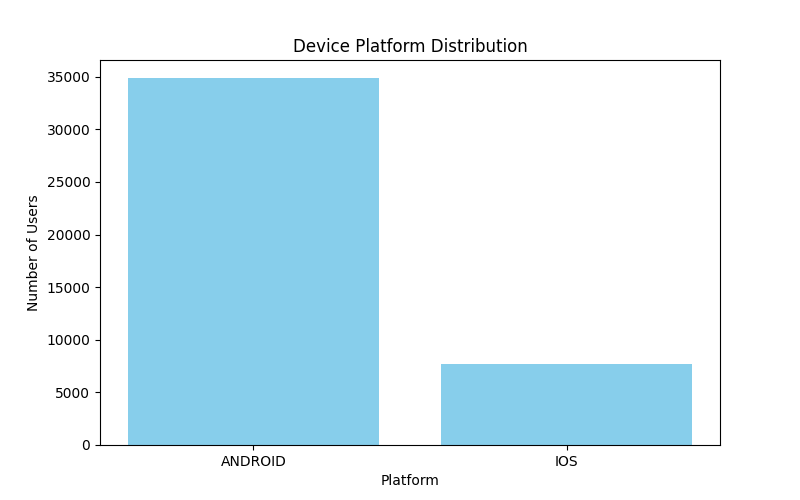

In [12]:
#Device Platform Distribution

platform_counts = user_stg.groupBy("platform").count().toPandas()
plt.figure(figsize=(8, 5))
plt.bar(platform_counts["platform"], platform_counts["count"], color='skyblue')
plt.title("Device Platform Distribution")
plt.xlabel("Platform")
plt.ylabel("Number of Users")
%matplot plt

Text(0.5, 1.0, 'Language Preference Distribution')



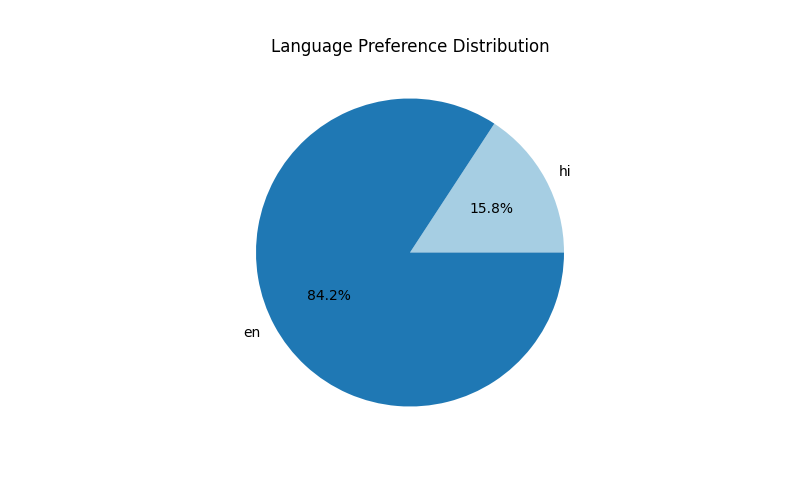

In [13]:
# Language Preference Distribution

lang_counts = user_stg.groupBy("lang").count().toPandas()
plt.figure(figsize=(8, 5))
plt.pie(lang_counts["count"], labels=lang_counts["lang"], autopct='%1.1f%%', colors=plt.cm.Paired(range(len(lang_counts))))
plt.title("Language Preference Distribution")
%matplot plt

(array([19723., 19727., 19731., 19735., 19739., 19743., 19747., 19751.,
       19754.]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])



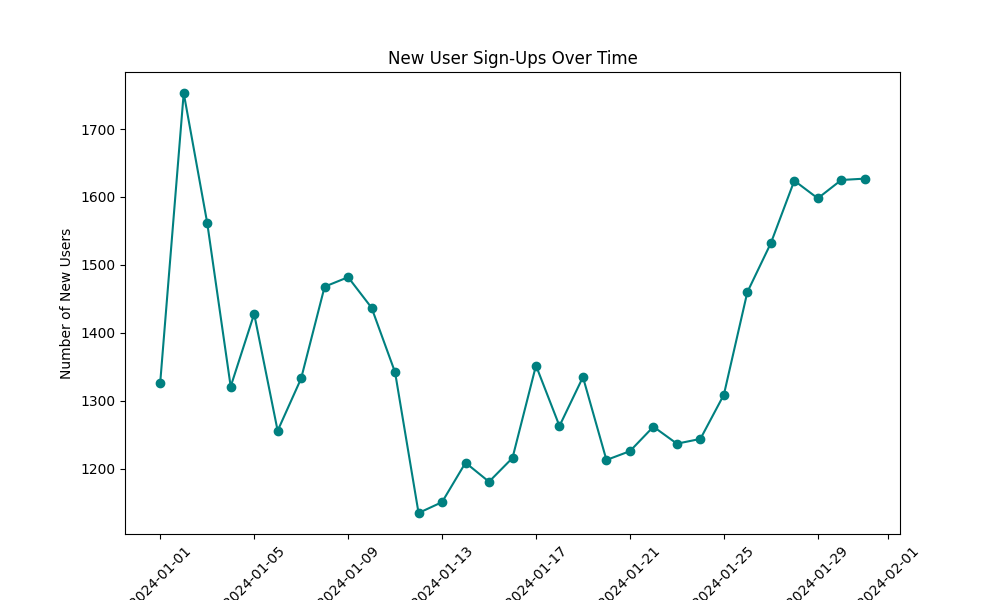

In [14]:
# Install Date Trend

install_trend = user_stg.groupBy("install_dt").count().orderBy("install_dt").toPandas()
plt.figure(figsize=(10, 6))
plt.plot(install_trend["install_dt"], install_trend["count"], marker='o', linestyle='-', color='teal')
plt.title("New User Sign-Ups Over Time")
plt.xlabel("Install Date")
plt.ylabel("Number of New Users")
plt.xticks(rotation=45)
%matplot plt

## Content Table Analysis

In [15]:
content.printSchema()
print(content.count())
content.show(5)

root
 |-- _id: string (nullable = true)
 |-- createdAt: timestamp (nullable = true)
 |-- newsLanguage: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- author: string (nullable = true)
 |-- batch_id: string (nullable = true)

113520
+----------+-------------------+------------+----------+--------------------+--------------+
|       _id|          createdAt|newsLanguage|categories|              author|      batch_id|
+----------+-------------------+------------+----------+--------------------+--------------+
|tiyvs4jq-1|2024-02-29 12:26:17|     english|      null|577d31fb10acb532f...|20250331082600|
|wnogviu3-1|2024-01-19 13:43:33|     english|      null|577d31fb10acb532f...|20250331082600|
|km8job1o-1|2024-03-05 11:33:09|     english|      null|577d31fb10acb532f...|20250331082600|
|jxgvya7s-1|2024-03-01 07:06:28|     english|      null|577d31fb10acb532f...|20250331082600|
|dxhkmfqz-1|2024-02-29 10:38:07|     english|      null|577d31fb10acb532f...|20250331082600|


### DQ Checks

In [16]:
# Primary Key Analysis - ID

# Unique Values
df_id = content.groupBy('_id').agg(count('_id').alias('count_id'))
df_id = df_id.filter(df_id.count_id > 1)
print(df_id.count())
# Null Values
df_null = content.filter(content._id.isNull())
print(df_null.count())

0
0


In [17]:
# Created At Column

df_crt = content.filter(content.createdAt.isNull())
print(df_crt.count())

0


In [18]:
# News Language Column

df_nl = content.select("newsLanguage").distinct()
df_nl.show(5)

df_nl_null = content.filter(content.newsLanguage.isNull())
print(df_nl_null.count())
df_nl_null.show(5)

# Null column must be removed

+------------+
|newsLanguage|
+------------+
|       hindi|
|     english|
|        null|
+------------+

178
+--------------------+--------------------+------------+----------+--------------------+--------------+
|                 _id|           createdAt|newsLanguage|categories|              author|      batch_id|
+--------------------+--------------------+------------+----------+--------------------+--------------+
|d35a14cd-f6f2-464...| 2016-04-27 10:14:44|        null|     world|                null|20250331082600|
|7414db98-0fbe-427...|2016-06-22 10:16:...|        null|     world|                null|20250331082600|
|81c48d17-6188-46e...|2016-06-10 11:43:...|        null|     world|                null|20250331082600|
|          gmoxjvnr-1| 2019-03-12 16:51:19|        null|     world|5748e05c947ce4454...|20250331082600|
|f9a72e5f-47fe-410...|2016-08-28 17:40:...|        null|     world|5769294910acb513d...|20250331082600|
+--------------------+--------------------+------------+--

In [19]:
# Categories Column

df_ct = content.select("categories").distinct()
df_ct.show(5)

df_ct_null = content.filter(content.categories.isNull())
print(df_ct_null.count())
df_ct_null.show(5)

# No need to remove Null Columns

+----------+
|categories|
+----------+
|       all|
|    travel|
|       IPL|
|      null|
|     world|
+----------+
only showing top 5 rows

3689
+----------+-------------------+------------+----------+--------------------+--------------+
|       _id|          createdAt|newsLanguage|categories|              author|      batch_id|
+----------+-------------------+------------+----------+--------------------+--------------+
|tiyvs4jq-1|2024-02-29 12:26:17|     english|      null|577d31fb10acb532f...|20250331082600|
|wnogviu3-1|2024-01-19 13:43:33|     english|      null|577d31fb10acb532f...|20250331082600|
|km8job1o-1|2024-03-05 11:33:09|     english|      null|577d31fb10acb532f...|20250331082600|
|jxgvya7s-1|2024-03-01 07:06:28|     english|      null|577d31fb10acb532f...|20250331082600|
|dxhkmfqz-1|2024-02-29 10:38:07|     english|      null|577d31fb10acb532f...|20250331082600|
+----------+-------------------+------------+----------+--------------------+--------------+
only showing top

In [20]:
# Different Categories present

df_cat_distinct = content.select(explode(split(content.categories,"\|")).alias("categories_distinct")).distinct()
print(df_cat_distinct.count())

94


In [21]:
# Author Column

df_auth = content.filter(content.author.isNull())
print(df_auth.count())

df_auth = df_auth.filter(content.newsLanguage.isNotNull())
print(df_auth.count())

# All are values where news language is also null

# Should be removed

18
0


### Data Standardization

In [6]:
# No Standardization is required

### Summary for Content Table -> DQ on NULL values of newsLanguage and author, No Standardization

In [22]:
# Expected drop of 178 rows
content_stg = content.na.drop(subset=["newsLanguage", "author"])
content_stg.printSchema()
print(content_stg.count())
content_stg.show(5)

root
 |-- _id: string (nullable = true)
 |-- createdAt: timestamp (nullable = true)
 |-- newsLanguage: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- author: string (nullable = true)
 |-- batch_id: string (nullable = true)

113342
+----------+-------------------+------------+----------+--------------------+--------------+
|       _id|          createdAt|newsLanguage|categories|              author|      batch_id|
+----------+-------------------+------------+----------+--------------------+--------------+
|tiyvs4jq-1|2024-02-29 12:26:17|     english|      null|577d31fb10acb532f...|20250331082600|
|wnogviu3-1|2024-01-19 13:43:33|     english|      null|577d31fb10acb532f...|20250331082600|
|km8job1o-1|2024-03-05 11:33:09|     english|      null|577d31fb10acb532f...|20250331082600|
|jxgvya7s-1|2024-03-01 07:06:28|     english|      null|577d31fb10acb532f...|20250331082600|
|dxhkmfqz-1|2024-02-29 10:38:07|     english|      null|577d31fb10acb532f...|20250331082600|


### Visualizations for Content Table

Text(0, 0.5, 'Number of Content Pieces')



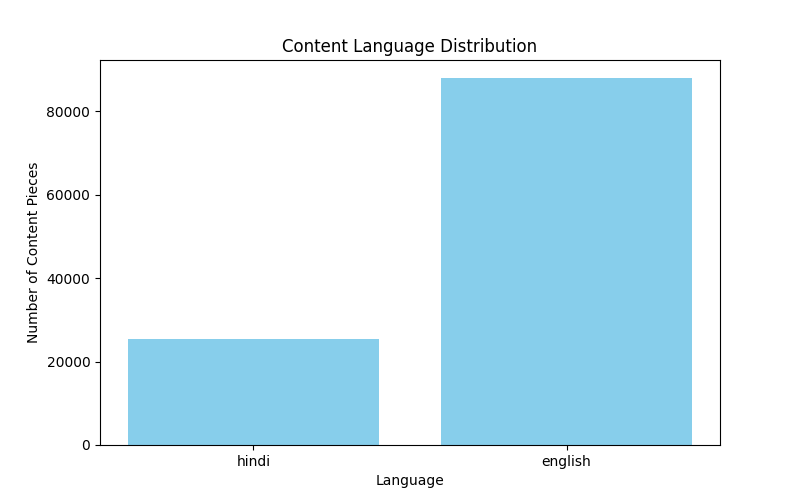

In [23]:
# Content Language Distribution

language_counts = content_stg.groupBy("newsLanguage").count().toPandas()
plt.figure(figsize=(8, 5))
plt.bar(language_counts["newsLanguage"], language_counts["count"], color='skyblue')
plt.title("Content Language Distribution")
plt.xlabel("Language")
plt.ylabel("Number of Content Pieces")
%matplot plt

In [24]:
# Max-min of createdAt Column

c = content_stg.select(max('createdAt'),min('createdAt'))
c.show()

+-------------------+-------------------+
|     max(createdAt)|     min(createdAt)|
+-------------------+-------------------+
|2024-05-03 04:47:25|2019-04-18 16:26:44|
+-------------------+-------------------+


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])



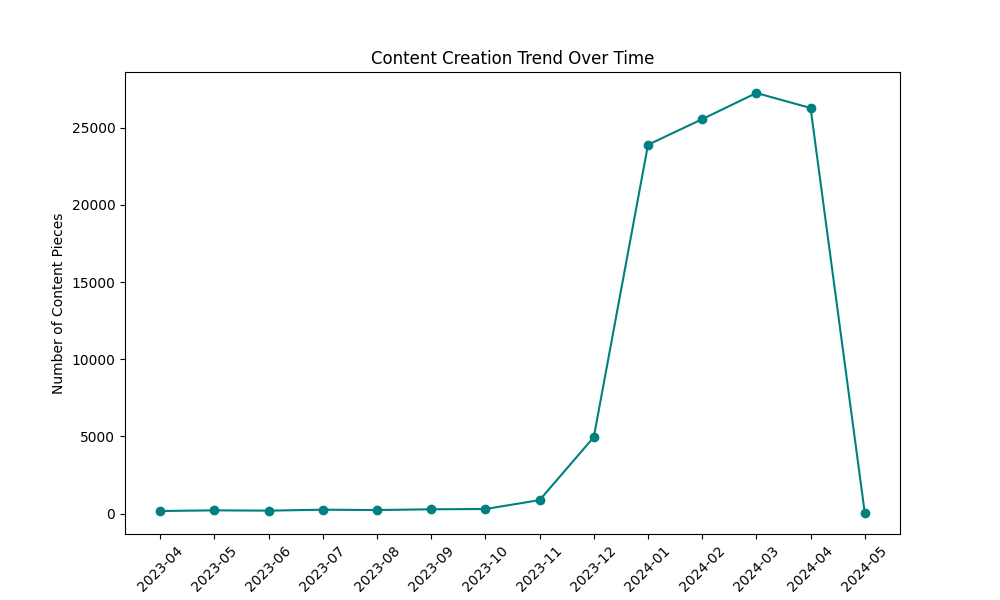

In [25]:
# Content Creation Trend Over Time - Last 2 years (monthly)

content_creation_trend = content_stg.filter(content_stg.createdAt > date_sub(current_date(), 730))
content_creation_trend = content_creation_trend.withColumn("month", date_format(col("createdAt"), "yyyy-MM"))
content_creation_trend = content_creation_trend.drop("createdAt").withColumnRenamed("month","createdAt")
creation_trend = content_creation_trend.groupBy("createdAt").count().orderBy("createdAt").toPandas()
creation_trend
plt.figure(figsize=(10, 6))
plt.plot(creation_trend["createdAt"], creation_trend["count"], marker='o', linestyle='-', color='teal')
plt.title("Content Creation Trend Over Time")
plt.xlabel("Creation Date")
plt.ylabel("Number of Content Pieces")
plt.xticks(rotation=45)
%matplot plt

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])



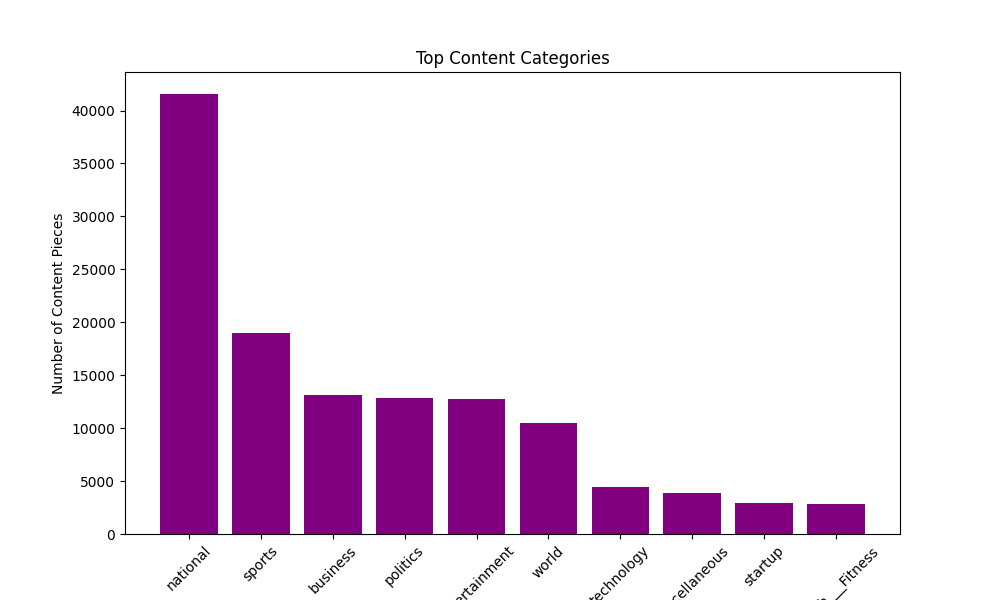

In [26]:
# Top 10 content categories

exploded_df = content_stg.withColumn("category", explode(split("categories", "\|")))
category_counts = exploded_df.groupBy("category").count().orderBy("count", ascending=False).limit(10).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(category_counts["category"], category_counts["count"], color='purple')
plt.title("Top Content Categories")
plt.xlabel("Category")
plt.ylabel("Number of Content Pieces")
plt.xticks(rotation=45)
%matplot plt

## Event Table Analysis

In [27]:
event.printSchema()
print(event.count())
event.show(5)

root
 |-- deviceid: string (nullable = true)
 |-- content_id: string (nullable = true)
 |-- eventtimestamp: long (nullable = true)
 |-- timespent: double (nullable = true)
 |-- eventname: string (nullable = true)
 |-- batch_id: string (nullable = true)

82440945
+--------------------+----------+--------------+-----------------+---------+--------------+
|            deviceid|content_id|eventtimestamp|        timespent|eventname|      batch_id|
+--------------------+----------+--------------+-----------------+---------+--------------+
|ios_415449B5-3DF7...|5gdezp0d-1| 1712062125000|4.955241918563843|    Front|20250331082600|
|7c6753d7-fe50-4c0...|4nbzv6nb-1| 1708436575000|             null|    Shown|20250331082600|
|e277cd5d-395b-419...|ztvxr6mi-1| 1708520644000|             null|    Shown|20250331082600|
|25f7d529-9d1a-499...|nyes7sqt-1| 1713031696000|             null|    Shown|20250331082600|
|6b30788b-ff00-48a...|ridrymra-1| 1708417553000|             null|    Shown|20250331082600|
+

In [28]:
# Foreign Key constraint on User Table

df_dev = event.join(user_stg,"deviceid","left_anti")
print(df_dev.count())

# Need to remove, because if device is not there how can a event is available on it

5338933


In [29]:
# Foreign Key constraint on Content Table

df_con = event.join(content_stg,event['content_id']==content_stg['_id'],"left_anti")
print(df_con.count())

# Need to remove, because if content is not there how can a event is available on it

8761


In [30]:
# Device Id Column

df_d = event.filter(event.deviceid.isNull())
print(df_d.count())

0


In [31]:
# Content Id Column

df_c = event.filter(event.content_id.isNull())
print(df_c.count())

# These null columns should be filtered when applying foreign key constarint

8342


In [32]:
# Null removes

df_con_rem = event.join(content_stg,event['content_id']==content_stg['_id'],"left_semi")
df_con_rem = df_con_rem.filter(df_con_rem.content_id.isNull())
print(df_con_rem.count())

0


In [33]:
# Eventtimestamp Column

df_ev = event.filter(event.eventtimestamp.isNull())
print(df_ev.count())

# Need to convert to timespamp in Data Standardization

0


In [34]:
# Timespent Column

df_ts = event.filter(event.timespent.isNull())
print(df_ts.count())
df_ts.show(5)

# Need to be use as 0 & change to 2 decimal values in Data Standardization

40809680
+--------------------+----------+--------------+---------+---------+--------------+
|            deviceid|content_id|eventtimestamp|timespent|eventname|      batch_id|
+--------------------+----------+--------------+---------+---------+--------------+
|7c6753d7-fe50-4c0...|4nbzv6nb-1| 1708436575000|     null|    Shown|20250331082600|
|e277cd5d-395b-419...|ztvxr6mi-1| 1708520644000|     null|    Shown|20250331082600|
|25f7d529-9d1a-499...|nyes7sqt-1| 1713031696000|     null|    Shown|20250331082600|
|6b30788b-ff00-48a...|ridrymra-1| 1708417553000|     null|    Shown|20250331082600|
|0f735e44-0700-4b5...|ag1gtfll-1| 1706577691000|     null|    Shown|20250331082600|
+--------------------+----------+--------------+---------+---------+--------------+
only showing top 5 rows


In [35]:
# Event Name Column

df_en = event.select('eventname').distinct()
df_en.show(10)

+---------+
|eventname|
+---------+
|    Shown|
|     Back|
|   Shared|
|   Opened|
|    Front|
+---------+


### Data Standardization

In [36]:
# Eventtimestamp & Timespent Column

df_std = event.select("deviceid","content_id",to_timestamp(from_unixtime(col("eventtimestamp")/1000),"yyyy-MM-dd HH:mm:ss").alias("eventtimestamp"),round(col("timespent"),2).alias("timespent"),"eventname","batch_id")
df_std = df_std.fillna(0, subset=["timespent"])
df_std.show(5)
df_std.printSchema()

+--------------------+----------+-------------------+---------+---------+--------------+
|            deviceid|content_id|     eventtimestamp|timespent|eventname|      batch_id|
+--------------------+----------+-------------------+---------+---------+--------------+
|ios_415449B5-3DF7...|5gdezp0d-1|2024-04-02 12:48:45|     4.96|    Front|20250331082600|
|7c6753d7-fe50-4c0...|4nbzv6nb-1|2024-02-20 13:42:55|      0.0|    Shown|20250331082600|
|e277cd5d-395b-419...|ztvxr6mi-1|2024-02-21 13:04:04|      0.0|    Shown|20250331082600|
|25f7d529-9d1a-499...|nyes7sqt-1|2024-04-13 18:08:16|      0.0|    Shown|20250331082600|
|6b30788b-ff00-48a...|ridrymra-1|2024-02-20 08:25:53|      0.0|    Shown|20250331082600|
+--------------------+----------+-------------------+---------+---------+--------------+
only showing top 5 rows

root
 |-- deviceid: string (nullable = true)
 |-- content_id: string (nullable = true)
 |-- eventtimestamp: timestamp (nullable = true)
 |-- timespent: double (nullable = fal

### Summary for Event Table -> DQ on Foreign Key Constraint of deviceid and content_id, Standardization on eventtimestamp & timespent column

In [37]:
# DQ
event_stg = event.join(user_stg,'deviceid','left_semi')
event_stg = event_stg.join(content_stg,event_stg['content_id']==content_stg['_id'],'left_semi')

# Data Standardization
event_stg = event_stg.select("deviceid","content_id",to_timestamp(from_unixtime(col("eventtimestamp")/1000),"yyyy-MM-dd HH:mm:ss").alias("eventtimestamp"), \
                             round(col("timespent"),2).alias("timespent"),"eventname","batch_id")
event_stg = event_stg.fillna(0, subset=["timespent"])

event_stg.printSchema()
print(event_stg.count())
event_stg.show(5)

root
 |-- deviceid: string (nullable = true)
 |-- content_id: string (nullable = true)
 |-- eventtimestamp: timestamp (nullable = true)
 |-- timespent: double (nullable = false)
 |-- eventname: string (nullable = true)
 |-- batch_id: string (nullable = true)

77093687
+--------------------+----------+-------------------+---------+---------+--------------+
|            deviceid|content_id|     eventtimestamp|timespent|eventname|      batch_id|
+--------------------+----------+-------------------+---------+---------+--------------+
|ios_415449B5-3DF7...|5gdezp0d-1|2024-04-02 12:48:45|     4.96|    Front|20250331082600|
|7c6753d7-fe50-4c0...|4nbzv6nb-1|2024-02-20 13:42:55|      0.0|    Shown|20250331082600|
|e277cd5d-395b-419...|ztvxr6mi-1|2024-02-21 13:04:04|      0.0|    Shown|20250331082600|
|6b30788b-ff00-48a...|ridrymra-1|2024-02-20 08:25:53|      0.0|    Shown|20250331082600|
|0f735e44-0700-4b5...|ag1gtfll-1|2024-01-30 01:21:31|      0.0|    Shown|20250331082600|
+------------------

### Visualization of Event Table

Text(0, 0.5, 'Number of Events')



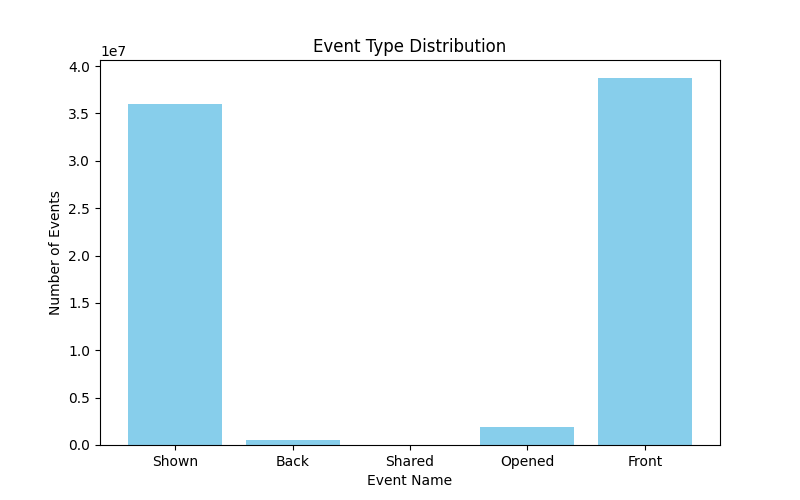

In [38]:
# Event Type Distribution

event_counts = event_stg.groupBy("eventname").count().toPandas()
plt.figure(figsize=(8, 5))
plt.bar(event_counts["eventname"], event_counts["count"], color='skyblue')
plt.title("Event Type Distribution")
plt.xlabel("Event Name")
plt.ylabel("Number of Events")
%matplot plt

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])



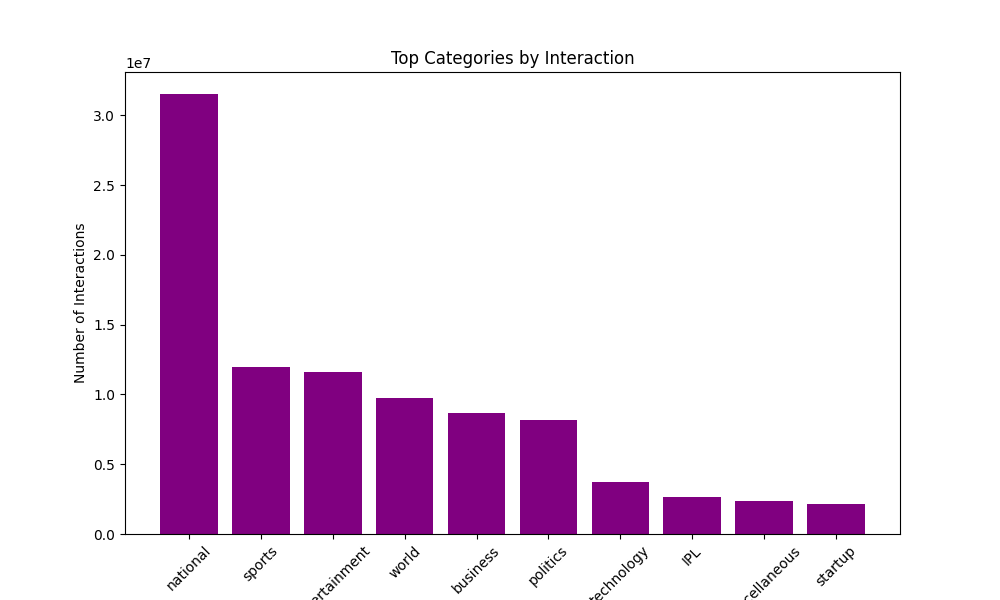

In [39]:
# Top Content Category by Interaction

event_df = event_stg.join(content_stg,event_stg['content_id']==content_stg['_id'],'inner')
exploded_df = event_df.withColumn("category", explode(split("categories", "\|")))
content_interactions = exploded_df.groupBy("category").count().orderBy("count", ascending=False).limit(10).toPandas()
plt.figure(figsize=(10, 6))
plt.bar(content_interactions["category"], content_interactions["count"], color='purple')
plt.title("Top Categories by Interaction")
plt.xlabel("Category")
plt.ylabel("Number of Interactions")
plt.xticks(rotation=45)
%matplot plt

In [40]:
# Max-min of eventtimestamp Column

e = event_stg.select(max('eventtimestamp'),min('eventtimestamp'))
e.show()

+-------------------+-------------------+
|max(eventtimestamp)|min(eventtimestamp)|
+-------------------+-------------------+
|2024-04-30 23:59:56|2024-01-01 00:09:44|
+-------------------+-------------------+


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])



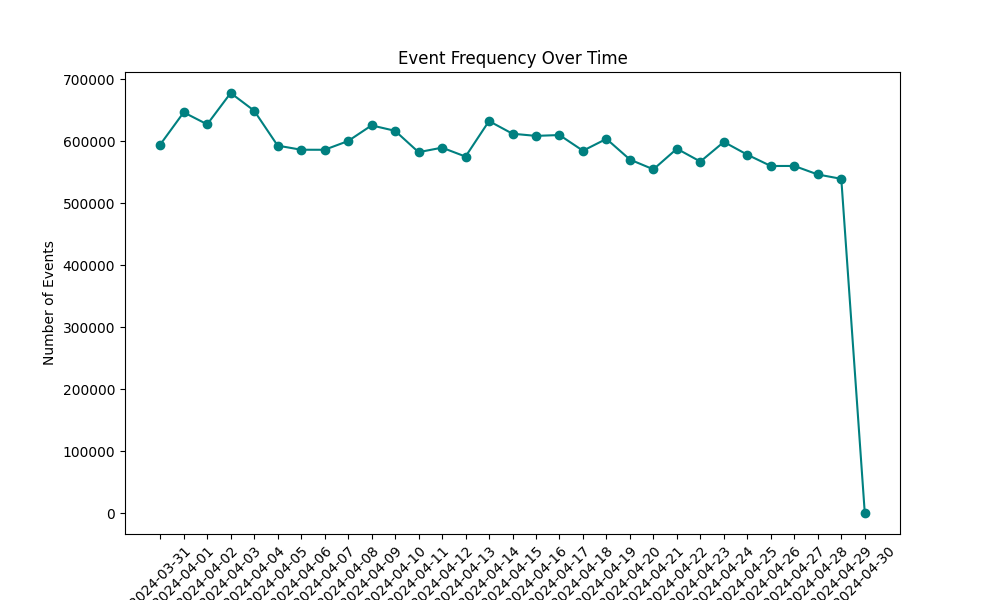

In [41]:
# Event Frequency Over Time - Last 2 years

# event_date_counts = event_stg.filter(event_stg.eventtimestamp > date_sub(current_date(), 30))

# Changing query for visualization of 30 Days
last_date = '2024-04-30'
event_date_counts = event_stg.filter((event_stg.eventtimestamp >= date_sub(lit(last_date), 30)) & (event_stg.eventtimestamp <= lit(last_date)))

event_date_counts = event_date_counts.withColumn("day", date_format(col("eventtimestamp"), "yyyy-MM-dd"))
event_date_counts = event_date_counts.drop("eventtimestamp").withColumnRenamed("day","eventtimestamp")
event_date_counts = event_date_counts.groupBy("eventtimestamp").count().orderBy("eventtimestamp").toPandas()

plt.figure(figsize=(10, 6))
plt.plot(event_date_counts["eventtimestamp"], event_date_counts["count"], marker='o', linestyle='-', color='teal')
plt.title("Event Frequency Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
%matplot plt